# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading data](#reading_data)    
    a. [Activity data](#activity_data)    
    b. [Molecular docking and molecular descriptors](#molecular)    
    
    
2. [Machine learning](#machine_learning)     
    a. [Constructing the models](#constructing_models)     
    b. [Evaluation metrics](#evaluation_metrics)     
    
    
3. [Performace analysis](#performance_analysis)    
    a. [Comparing models and labels](#comparing)    
    b. [Finding the best subset](#finding)      
    c. [Reconstructing the top models](#reconstructing)    
    d. [ROC curves](#roc_curves)    
    e. [Regression plots](#regression)    
    
    
4. [Supplementary data](#supplementary)    

<a id='reading_data'></a>
## Reading data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='activity_data'></a>
### Activity data

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


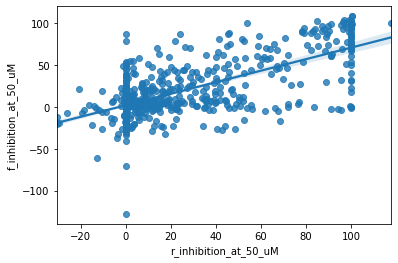

In [3]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

In [4]:
# Write into smiles
activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)

from rdkit import Chem
from rdkit.Chem import AllChem
suppl = Chem.SmilesMolSupplier('smiles.smi')

In [5]:
#for mol in suppl:
#    print(mol.GetNumAtoms())
#    print(Chem.MolToMolBlock(mol))
#    break
    
#mols = [x for x in suppl]
#len(mols)

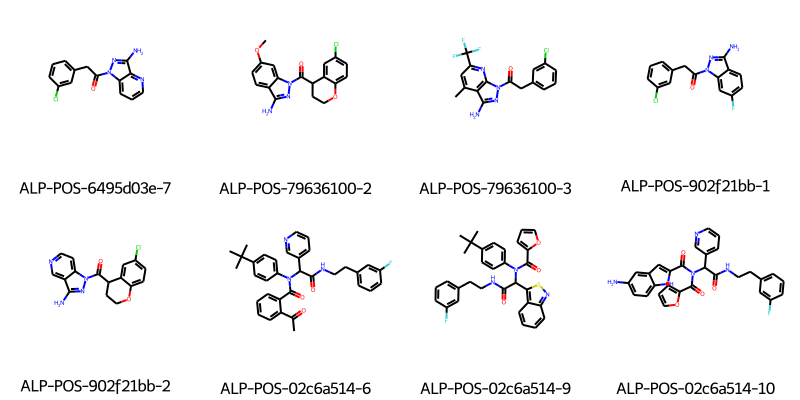

In [6]:
from rdkit.Chem import Descriptors

# Compute 2D coordinates
ms = [x for x in suppl if x is not None]
#for m in ms: 
#    tmp=AllChem.Compute2DCoords(m)
#    print(tmp)

d_list = []

for m in ms:
    d_list.append({'CID': m.GetProp('_Name'), 
                   'MolMR': Descriptors.MolMR(m), 
                   'NumRotatableBonds': Descriptors.NumRotatableBonds(m), 
                   'NumHAcceptors': Descriptors.NumHAcceptors(m), 
                   'NumHDonors': Descriptors.NumHDonors(m), 
                   'TPSA': Descriptors.LabuteASA(m), 
                   'LabuteASA': Descriptors.LabuteASA(m), 
                   'MolLogP': Descriptors.MolLogP(m)})

descriptors = pd.DataFrame(d_list)

# Draw
from rdkit.Chem import Draw
Draw.MolsToGridImage(ms[:8],
                     molsPerRow=4,
                     subImgSize=(200,200),
                     legends=[x.GetProp("_Name") for x in ms[:8]])    

<a id='molecular'></a>
### Molecular docking and molecular descriptors

In [7]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']])
del tmp

# Merge descriptors to "top"
data = pd.merge(descriptors, top)

#data.rename({'VABC Volume Descriptor': 'Volume', 
#             'Rotatable Bonds Count': 'RotatableBonds', 
#             'Topological Polar Surface Area': 'TPSA', 
#             'Molecular Weight': 'MolecularWeight'}, axis=1, inplace=True)
#data['Volume'] = data['Volume'].astype(float)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data

,CID,MolMR,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,f_inhibition_at_50_uM,r_active,f_active
0,MAT-POS-02ae579f-1,142.9562,8,3,1,216.479769,216.479769,6.46320,-7.7,7.746907,-93.0745,7.544520,NaN,0.007703,0,0
1,MAT-POS-02ae579f-2,73.8221,2,3,3,115.581247,115.581247,1.51050,-7.2,6.285345,-80.1747,6.407342,NaN,2.287651,0,0
2,LOR-NOR-f9b26152-1,45.9122,1,3,1,78.672385,78.672385,0.96910,-5.5,4.929599,-59.7841,5.100658,7.794489,3.016446,0,0
3,LON-WEI-2e27a2e5-2,146.2802,8,4,1,222.124736,222.124736,5.66020,-7.3,7.575922,-97.6586,7.776974,NaN,-6.337255,0,0
4,MAT-POS-af71705c-1,86.0674,2,4,2,125.972082,125.972082,2.57750,-6.2,6.609277,-54.8444,6.834465,0.000000,-0.727192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,DAR-DIA-23aa0b97-15,66.1254,2,3,2,102.857248,102.857248,2.77400,-6.2,5.479310,-62.0836,5.861192,-0.075000,16.821870,0,0
939,DAR-DIA-23aa0b97-17,65.5227,3,4,1,104.126584,104.126584,1.52948,-6.5,6.595699,-74.1667,7.054006,12.695000,21.805805,0,0
940,DAR-DIA-23aa0b97-19,85.2337,3,3,1,127.588600,127.588600,3.28768,-6.6,6.733870,-79.4982,6.852397,85.160000,73.019885,1,1
941,DAR-DIA-23aa0b97-20,80.5187,3,2,1,116.831078,116.831078,3.41600,-7.0,6.307346,-77.3610,6.383954,62.475000,57.793870,1,1


In [8]:
# Descriptors
descriptor_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

train_set = descriptor_list + docking_list

data.dropna(subset=train_set, inplace=True)

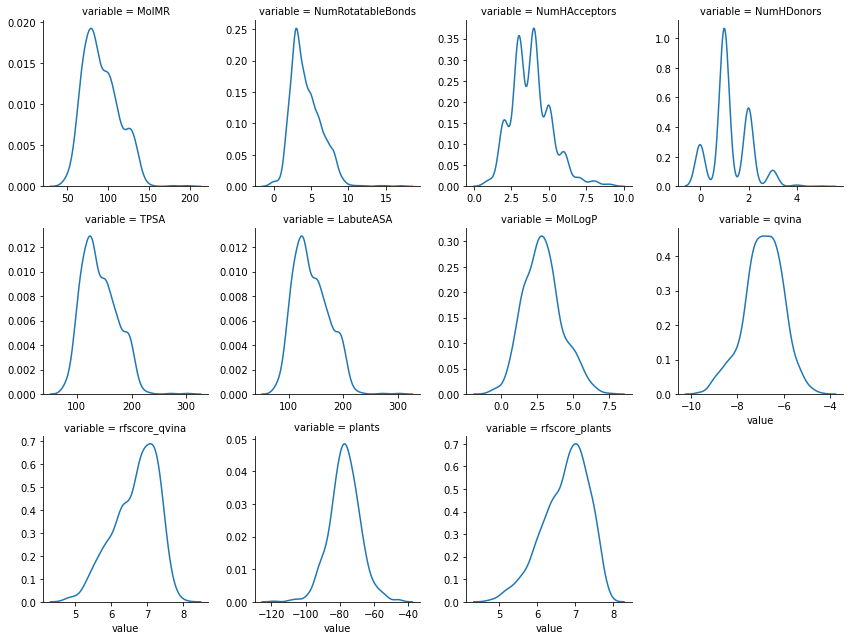

In [9]:
melt = pd.melt(data, id_vars=['CID'], value_vars=train_set)
g = sns.FacetGrid(data=melt, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value')

In [10]:
def qq_plot(X):
    from scipy.stats import probplot

    ncol = 4
    nrow = int(np.ceil(len(X.columns) / ncol))
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 4.8, nrow * 4.8))
    for i, x in enumerate(X.columns):
        probplot(data[x], dist='norm', plot=ax[i%nrow, i%ncol])
        ax[i%nrow, i%ncol].set_title(x)

    fig.tight_layout()
    plt.show()

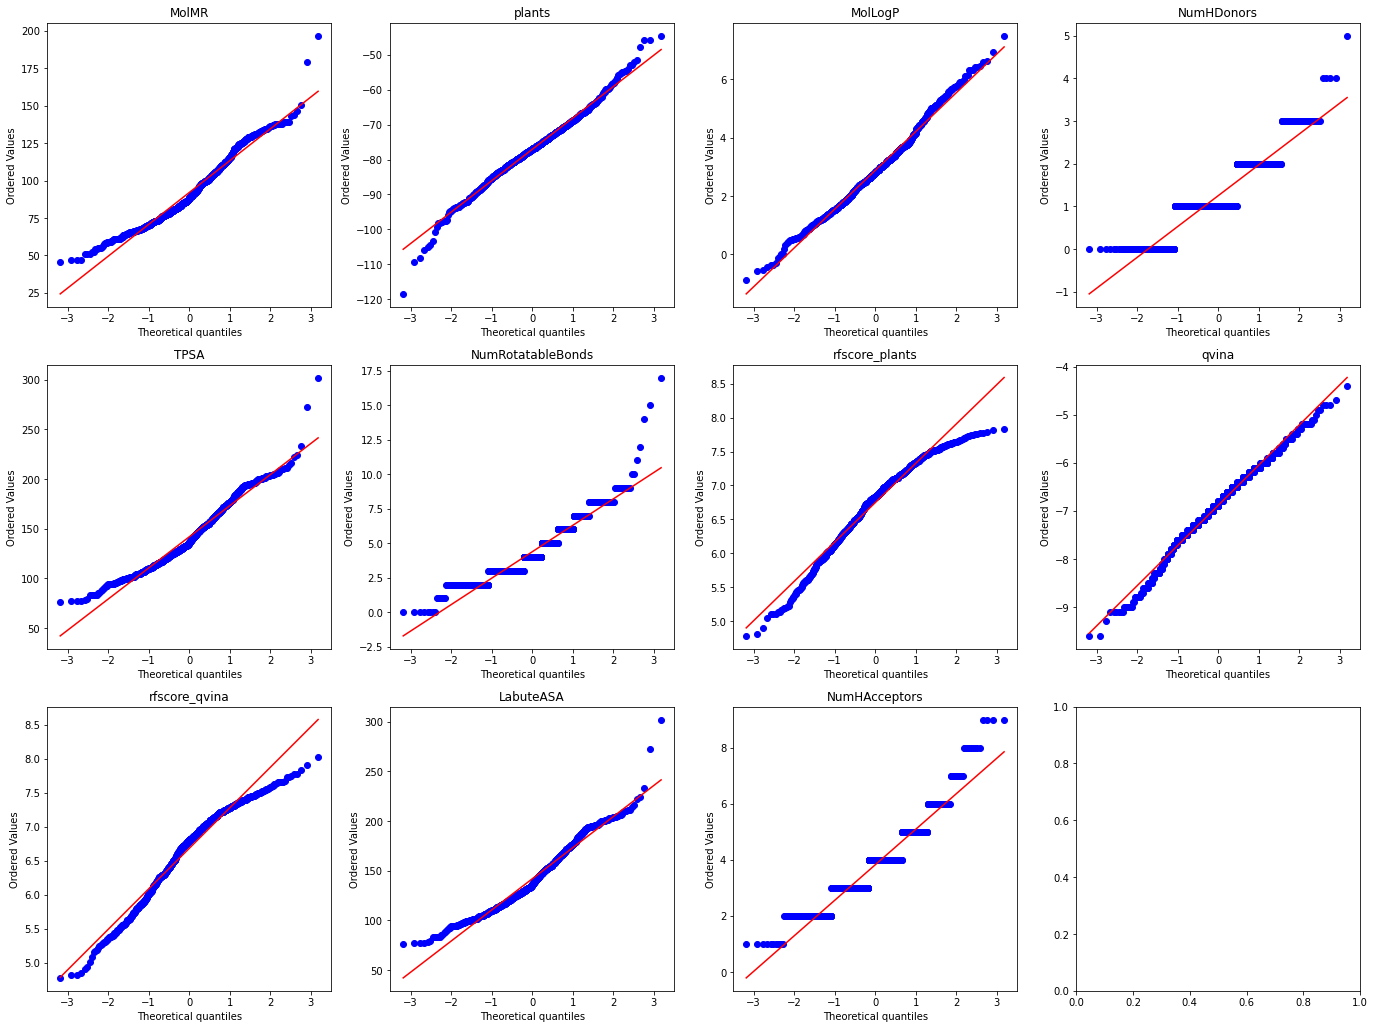

In [11]:
qq_plot(data[train_set])

The data is approximately normaly distributed, and can be standardized. However, some descriptors present skewness and the QQ-Plot shows the outermost data has greater variance, which could indicate heteroskedacity (non-constant variance). Therefore, the data will be rescaled with PowerTransformer(), which normalizes data and minimizes its skewness, making it more Gaussian-like, according to the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html). 

<a id='machine_learning'></a>
## Machine learning

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import multiprocessing
from functools import partial
import itertools
import time

<a id='constructing_models'></a>
### Constructing the models

In [13]:
# Get all subsets of a "main" list and N other lists
def get_combinations(min_len, list1, *args):
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(itertools.combinations(list2, r) for r in range(min_len, len(list2)+1)))
    
    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [14]:
# Rebalance data with SMOTE and cross validate model
def get_scores(X_train, X_test, y_train, y_test, subset, train_set, scaler, activity_label, model):
    pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
    model_fitted = pipe.fit(X_train, y_train)
    
    y_pred = model_fitted.predict(X_test)
        
    scores = [accuracy_score(y_test, y_pred), # test_accuracy
              precision_score(y_test, y_pred), # test_precision
              recall_score(y_test, y_pred), # test_recall
              f1_score(y_test, y_pred), # test_f1
              fbeta_score(y_test, y_pred, beta=2), # test_f2
              geometric_mean_score(y_test, y_pred), # test_g_mean
              roc_auc_score(y_test, y_pred) # test_roc_auc
             ]
    
    scores.append(activity_label)
    scores.append(str(model).split('(')[0])
    
    # Add binary list of the descriptors
    scores.extend([i in subset for i in train_set])
    
    return scores

In [15]:
def run_models(data, scaler, train_set, combinations, columns):
    ncpu = multiprocessing.cpu_count()

    # DataFrame for all models' scores
    scores_data = pd.DataFrame()

    model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                     RandomForestClassifier(n_estimators=10, random_state=13), 
                     KNeighborsClassifier(n_neighbors=5), 
                     LinearSVC(dual=False, random_state=13), 
                     XGBClassifier(objective='reg:logistic', random_state=13), 
                     DecisionTreeClassifier(random_state=13), 
                     LinearDiscriminantAnalysis(solver='svd')]
    
    for activity_label in ['r_active','f_active']:
        # Drop NaN activity and descriptor values
        new_data = data.dropna(subset=[activity_label])

        # Loop through all subset combinations (2, N)
        for subset in combinations:
            subset = list(subset)
            
            y = new_data[activity_label]
            X = new_data[subset]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

            # List of tuples for pool.map()
            args = []
            for model in model_list:
                args.append((activity_label, model))
            
            with multiprocessing.Pool(processes=ncpu) as pool:
                scores = pool.starmap(partial(get_scores, X_train, X_test, y_train, y_test, 
                                              subset, train_set, scaler), args)

            # Append scores to all scores
            scores = pd.DataFrame(scores, columns=columns+train_set)
            scores_data = scores_data.append(scores)
                
    return scores_data

<a id='evaluation_metrics'></a>
### Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [16]:
# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptor_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','g_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]

columns = [*test_metrics, 'activity_label', 'model']

In [17]:
t0 = time.time()

## Run all!
scores_data = run_models(data, StandardScaler(), train_set, combinations, columns)
scores_data[train_set] = scores_data[train_set].astype(int)
scores_data.to_csv('scores_data.csv', index=False)

t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

18m:32.9059s


<a id='performance_analysis'></a>
## Performance analysis

In [18]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv')
columns = scores_data.columns

selected = ['test_f2', 'test_g_mean', 'test_roc_auc']
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.groupby('model').head(1)

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_g_mean,test_roc_auc,activity_label,model,MolMR,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
6121,0.771186,0.342466,0.806452,0.480769,0.634518,0.785891,0.786153,r_active,LinearSVC,1,...,1,1,1,1,1,0,0,1,0,0.735520
11890,0.843220,0.448980,0.687500,0.543210,0.621469,0.772339,0.777574,f_active,XGBClassifier,0,...,1,1,1,0,1,0,0,1,0,0.723794
5718,0.750000,0.320513,0.806452,0.458716,0.618812,0.773275,0.773958,r_active,LinearDiscriminantAnalysis,0,...,1,1,1,0,0,0,0,1,1,0.722015
5600,0.745763,0.316456,0.806452,0.454545,0.615764,0.770727,0.771518,r_active,LogisticRegression,1,...,1,1,0,0,1,0,0,1,1,0.719336
2997,0.860169,0.476190,0.645161,0.547945,0.602410,0.758897,0.768922,r_active,RandomForestClassifier,0,...,1,1,1,1,1,0,0,0,0,0.710076
8843,0.733051,0.308642,0.781250,0.442478,0.598086,0.752854,0.753370,f_active,KNeighborsClassifier,1,...,1,1,0,0,1,1,0,0,0,0.701437
1391,0.800847,0.362069,0.677419,0.471910,0.576923,0.745086,0.748466,r_active,DecisionTreeClassifier,0,...,0,1,0,0,1,1,0,0,0,0.690158


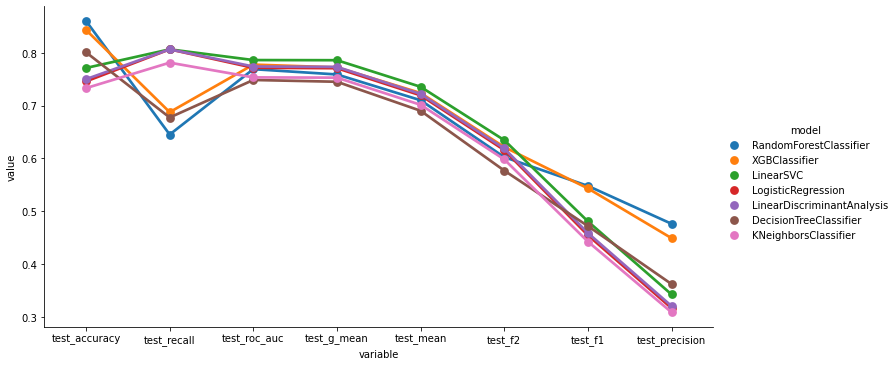

In [19]:
top = pd.melt(scores_data.groupby('model').head(1), id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', aspect=2)
plt.savefig('test_performance.png')

<a id='comparing'></a>
### Comparing models and labels

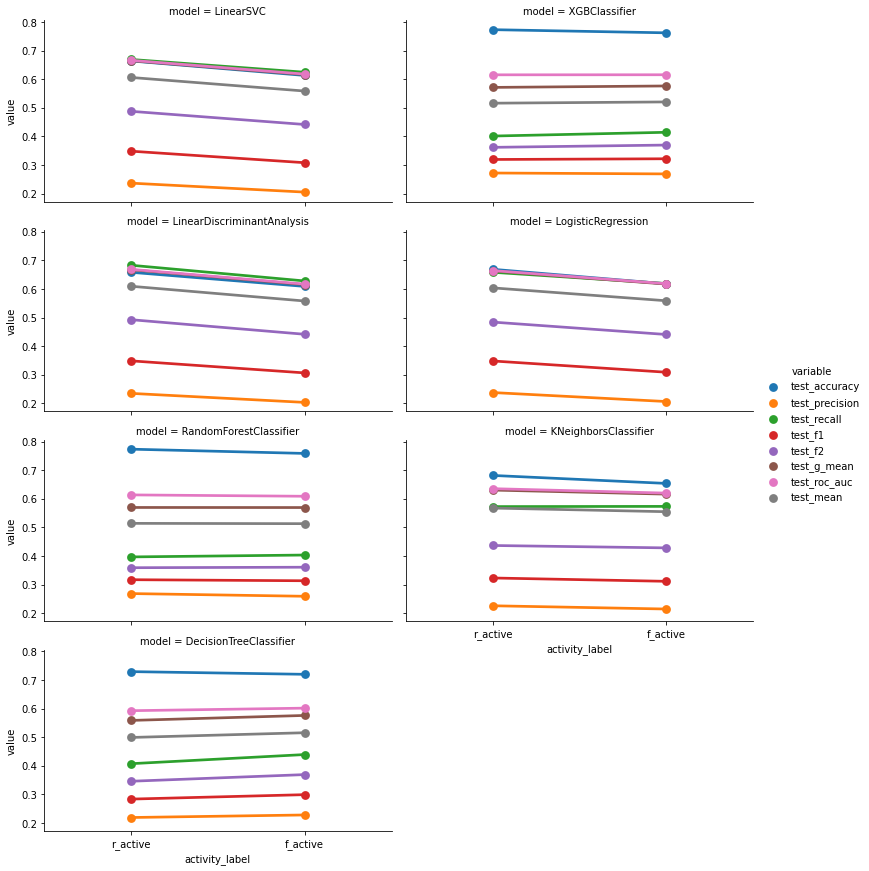

In [20]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)
plt.savefig('hue.png')

We see here the best classification metric ("RapidFire" or fluorescence) varies a bit for each model. While Linear SVC and Logistic Regression performed better with "RapidFire" activity labels, K-Nearest Neighbors and Random Forest classifiers performed better with the fluorescence activity labels.
<a id='finding'></a>
### Finding the best subset

In [21]:
# Dictionary: key == model_name, value == tuple(activity label, list of best descriptors)
best_subset = {}

for i, row in scores_data.groupby('model').head(1).iterrows():
    best_subset[row['model']] = [row['activity_label']]
    best_subset[row['model']].append([descriptor for descriptor in train_set if row[descriptor]])

In [22]:
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])

Text(0.5, 1.05, 'test_roc_auc')

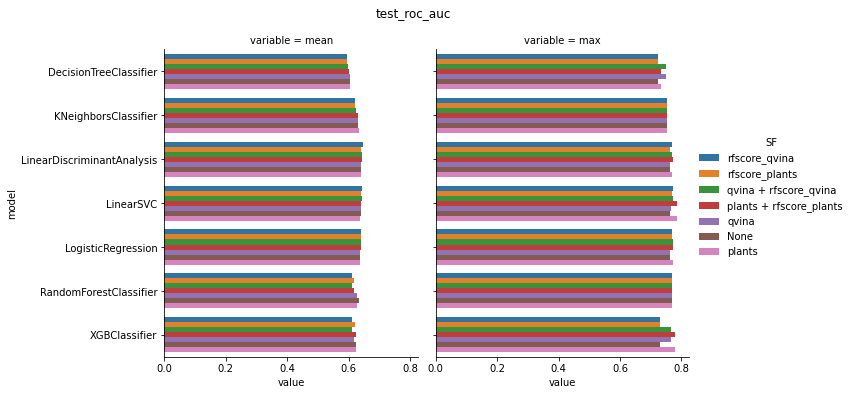

In [23]:
# Do the scores increase when I add the docking scoring functions?
sns.catplot(kind='bar', data=compare, y='model', x='value', col='variable', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.     
<a id='reconstructing'></a>
### Reconstructing the top models

In [24]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

In [41]:
def get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted):    
    y_pred_train = model_fitted.predict(X_train)
    y_pred_test = model_fitted.predict(X_test)
    
    scores = [fbeta_score(y_test, y_pred_test, beta=2), # test_f1
              geometric_mean_score(y_test, y_pred_test), # test_g_mean
              roc_auc_score(y_test, y_pred_test), # test_roc_auc
              fbeta_score(y_train, y_pred_train, beta=2), # train_f1
              geometric_mean_score(y_train, y_pred_train), # train_g_mean
              roc_auc_score(y_train, y_pred_train), # train_roc_auc
             ]
    
    return scores

In [42]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        model = LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        model = CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=10, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(objective='reg:logistic', random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        model = LinearDiscriminantAnalysis(solver='svd')
    else:
        model = None
    return model

In [43]:
# Top models' probabilities
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List with each top model's scores
scores_list = []
new_data = data.dropna(subset=train_set)

count = 0
for key, value in best_subset.items():
    model_name = key
    activity_label = value[0]
    subset = value[1]
    
    y = new_data[activity_label]
    X = new_data[subset]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
    
    scaler = StandardScaler()
    
    model = make_pipeline(SMOTE(random_state=42), scaler, get_model_by_name(model_name))

    model_fitted = model.fit(X_train, y_train)
    scores = get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted)
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
columns = ['model', *test_metrics, *train_metrics]

top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

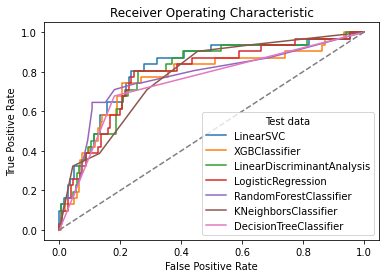

In [44]:
# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    plt.plot(fpr_test, tpr_test, label=f'{model_name}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Some legends
plt.legend(title='Test data')
plt.title('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

,model,test_f2,test_g_mean,test_roc_auc,train_f2,train_g_mean,train_roc_auc,test_mean,train_mean
0,LinearSVC,0.592784,0.756197,0.756334,0.453048,0.639495,0.652270,0.701771,0.581604
1,XGBClassifier,0.621469,0.772339,0.777574,1.000000,1.000000,1.000000,0.723794,1.000000
2,LinearDiscriminantAnalysis,0.618812,0.773275,0.773958,0.483129,0.656933,0.659635,0.722015,0.599899
3,LogisticRegression,0.615764,0.770727,0.771518,0.483360,0.660452,0.665891,0.719336,0.603234
4,RandomForestClassifier,0.602410,0.758897,0.768922,0.956439,0.975049,0.975138,0.710076,0.968875
5,KNeighborsClassifier,0.598086,0.752854,0.753370,0.684122,0.814510,0.814519,0.701437,0.771050
6,DecisionTreeClassifier,0.576923,0.745086,0.748466,0.992366,0.995227,0.995238,0.690158,0.994277


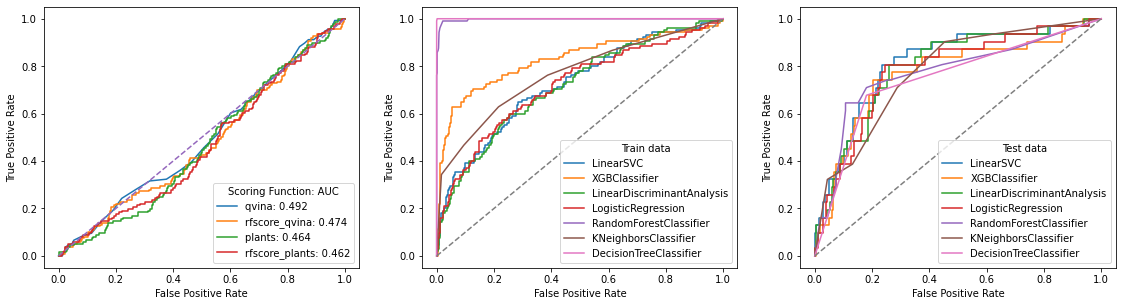

In [45]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data['r_active'].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

top_scores

We can see that Logistic Regression and Linear SVC were the best models and that they yielded very similar results.         
Considering Logistic Regression is the most frequent one in the top scores, we can assume it is the most adequate model for our problem.

<a id='regression'></a>
### Regression plots

In [30]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

del tmp

Text(0.5, 0.98, 'Regression plots for the test set')

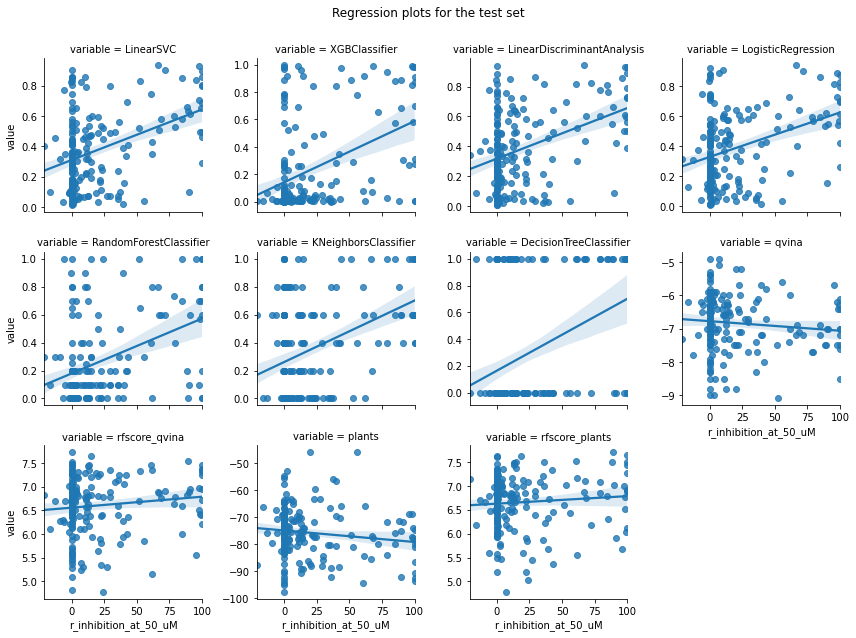

In [31]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'r_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

In [32]:
# Pearson correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.669436
f_inhibition_at_50_uM,0.669436,1.000000
DecisionTreeClassifier,0.375948,0.287059
KNeighborsClassifier,0.417687,0.384996
LinearDiscriminantAnalysis,0.416841,0.344617
LinearSVC,0.410482,0.336286
LogisticRegression,0.375787,0.318684
RandomForestClassifier,0.416588,0.288211
XGBClassifier,0.438372,0.450658


In [33]:
# Spearman correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.491688
f_inhibition_at_50_uM,0.491688,1.000000
DecisionTreeClassifier,0.284765,0.214564
KNeighborsClassifier,0.278419,0.308802
LinearDiscriminantAnalysis,0.289171,0.321862
LinearSVC,0.273847,0.304409
LogisticRegression,0.253518,0.289936
RandomForestClassifier,0.307417,0.190438
XGBClassifier,0.330896,0.313506


<a id='supplementary'></a>
## Supplementary data

In [34]:
df = scores_data.groupby(['model','activity_label']).describe()

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_active               884.0  0.719682  0.038008   
                           r_active               884.0  0.729058  0.038102   
KNeighborsClassifier       f_active               884.0  0.653597  0.045307   
                           r_active               884.0  0.681494  0.046148   
LinearDiscriminantAnalysis f_active               884.0  0.608861  0.061261   
                           r_active               884.0  0.658175  0.063358   
LinearSVC                  f_active               884.0  0.612940  0.063413   
                           r_active               884.0  0.663591  0.066105   
LogisticRegression         f_active               884.0  0.618021  0.062254   
                           r_active               884.0  0.668753  0.066533   
RandomForestClassifier     f_active               884.0  0.758422  0.040659   
                           r_active               884.0  0.773291  0.043213   
XGBClassifier              f_active               884.0  0.761887  0.046643   
                           r_active               884.0  0.772946  0.049917   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_active        0.567797  0.699153  0.724576   
                           r_active        0.525424  0.707627  0.733051   
KNeighborsClassifier       f_active        0.529661  0.622881  0.656780   
                           r_active        0.546610  0.656780  0.682203   
LinearDiscriminantAnalysis f_active        0.406780  0.567797  0.610169   
                           r_active        0.415254  0.622881  0.673729   
LinearSVC                  f_active        0.406780  0.572034  0.614407   
                           r_active        0.415254  0.627119  0.677966   
LogisticRegression         f_active        0.402542  0.583686  0.622881   
                           r_active        0.415254  0.627119  0.686441   
RandomForestClassifier     f_active        0.538136  0.736229  0.762712   
                           r_active        0.525424  0.750000  0.779661   
XGBClassifier              f_active        0.559322  0.733051  0.771186   
                           r_active        0.521186  0.745763  0.783898   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_active        0.750000  0.805085          884.0   
                           r_active        0.754237  0.813559          884.0   
KNeighborsClassifier       f_active        0.686441  0.796610          884.0   
                           r_active        0.711864  0.792373          884.0   
LinearDiscriminantAnalysis f_active        0.661017  0.724576          884.0   
                           r_active        0.703390  0.766949          884.0   
LinearSVC                  f_active        0.662076  0.737288          884.0   
                           r_active        0.711864  0.775424          884.0   
LogisticRegression         f_active        0.665254  0.737288          884.0   
                           r_active        0.720339  0.771186          884.0   
RandomForestClassifier     f_active        0.788136  0.834746          884.0   
                           r_active        0.805085  0.860169          884.0   
XGBClassifier              f_active        0.796610  0.868644          884.0   
                           r_active        0.809322  0.877119          884.0   

                                                             

Text(0.5, 0.98, 'Most frequent descriptors in the top 1% scores')

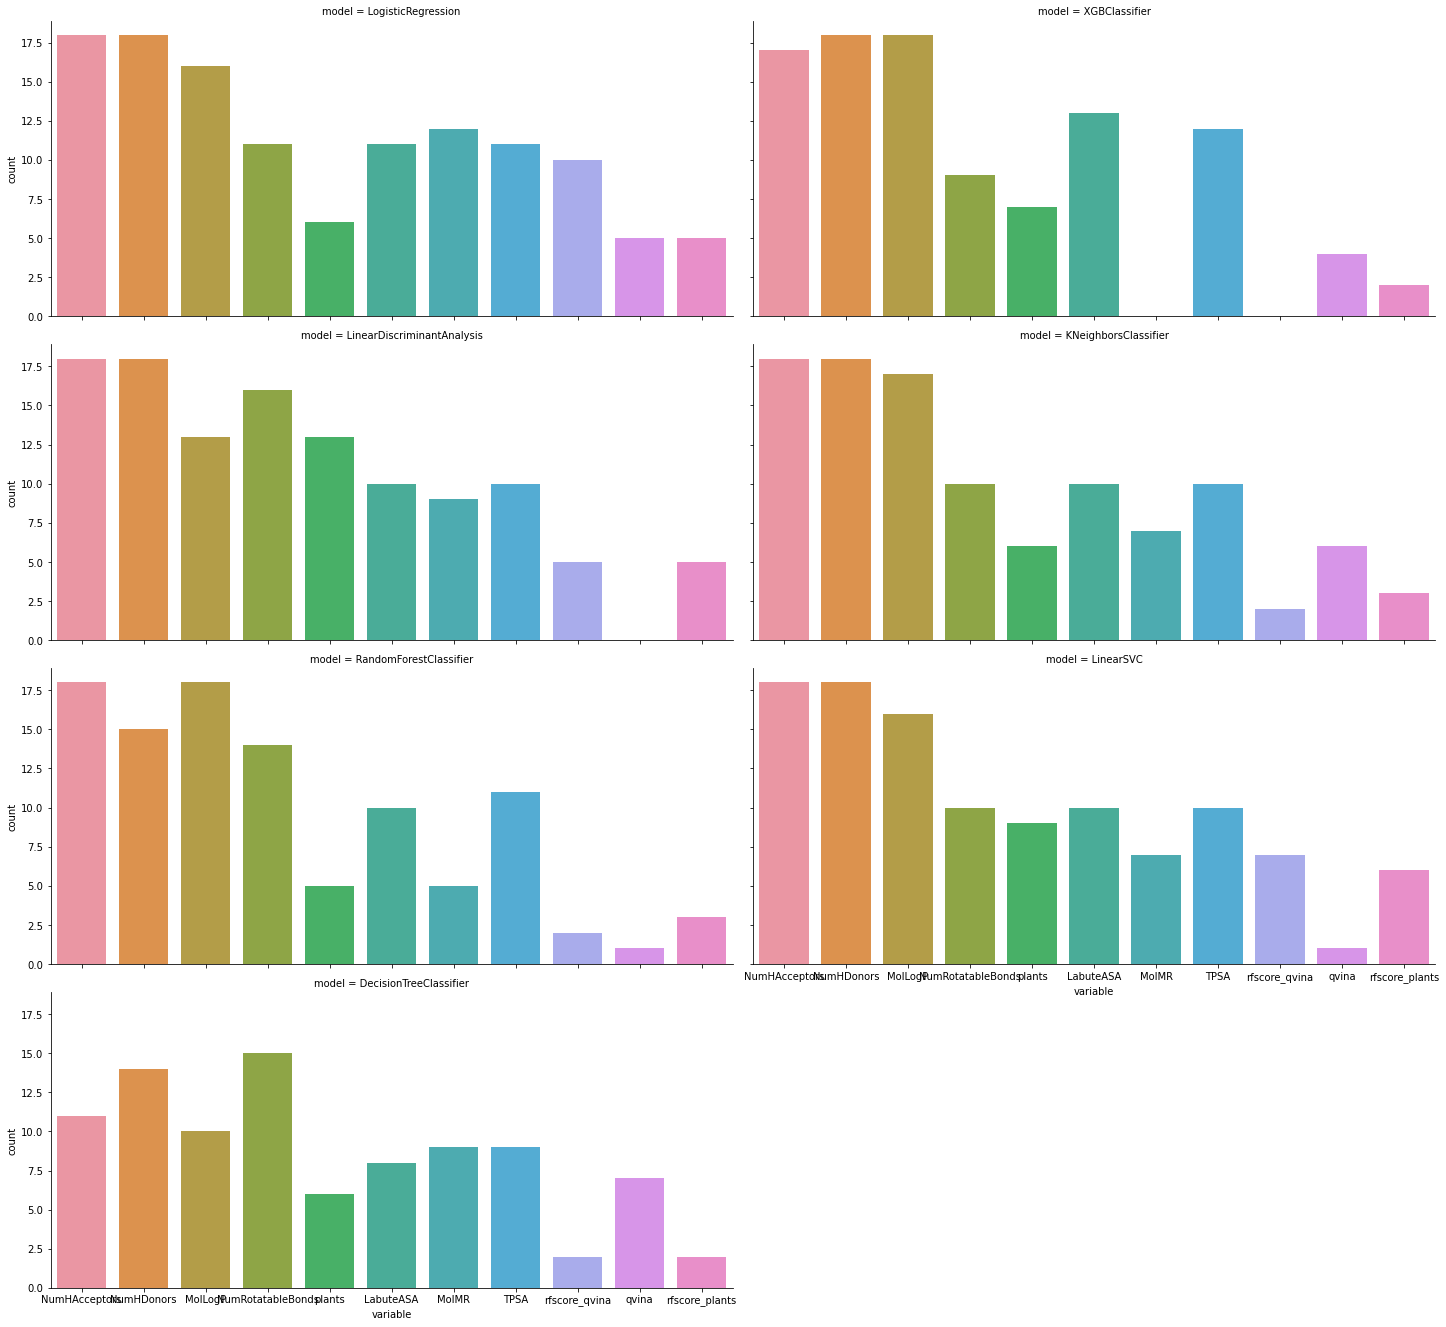

In [36]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=train_set, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most frequent descriptors in the top 1% scores')

The frequency count shows the most recurring descriptors in each model's top 1% results are: 

In [37]:
for key, value in best_subset.items():
    print(key, end=': ')
    for i in value[1][:-1]:
        print(i, end=', ')
    print(value[1][-1])
    print()

LinearSVC: MolMR, NumRotatableBonds, NumHAcceptors, NumHDonors, TPSA, LabuteASA, MolLogP, plants

XGBClassifier: NumRotatableBonds, NumHAcceptors, NumHDonors, TPSA, MolLogP, plants

LinearDiscriminantAnalysis: NumRotatableBonds, NumHAcceptors, NumHDonors, TPSA, plants, rfscore_plants

LogisticRegression: MolMR, NumHAcceptors, NumHDonors, MolLogP, plants, rfscore_plants

RandomForestClassifier: NumRotatableBonds, NumHAcceptors, NumHDonors, TPSA, LabuteASA, MolLogP

KNeighborsClassifier: MolMR, NumRotatableBonds, NumHAcceptors, NumHDonors, MolLogP, qvina

DecisionTreeClassifier: NumRotatableBonds, NumHDonors, MolLogP, qvina



In [38]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

value = best_subset['XGBClassifier']
model_name = 'XGBClassifier'
activity_label = value[0]
subset = value[1]

y = new_data[activity_label]
X = new_data[subset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

RMSE: 0.3631
log_loss: 0.4998


,0,1
0,0.867647,0.132353
1,0.312500,0.687500


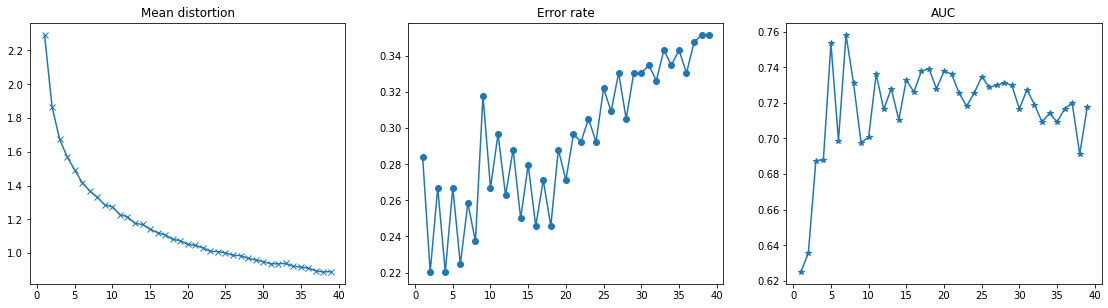

In [39]:
# Finding the optimal K value for KNeighborsClassifier

from sklearn.cluster import KMeans
from scipy.spatial import distance

value = best_subset['KNeighborsClassifier']
model_name = 'KNeighborsClassifier'
activity_label = value[0]
subset = value[1]

y = new_data[activity_label]
X = new_data[subset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K = range(1, 40) 
mean_distortions = []
error_rate = []
auc_list = []
fig, ax = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))

for i in K:
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(X_train)
    mean_distortions.append(sum(np.min(distance.cdist(X_train, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    auc_list.append(roc_auc_score(y_test, pred_i))

ax[0].plot(K, mean_distortions, 'x-')
ax[1].plot(K, error_rate, 'o-', label='')
ax[2].plot(K, auc_list, '*-')
ax[0].set_title('Mean distortion')
ax[1].set_title('Error rate')
ax[2].set_title('AUC')
plt.show()

In [40]:
# Completar overview
